<a href="https://colab.research.google.com/github/vhaghani26/BST_227_Code/blob/main/NN_6_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required packages

In [1]:
import torch
import torch.optim as optim

In [2]:
## Plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_scatter(X_in, label, labels_dict={}, hue = 'Label', method = 'pca', **kwargs):
    """ Create scatterplots of data x with label after dimensionality reduction (if needed) """

    if X_in.shape[-1] > 2:
      if method == 'pca':
        pca = PCA(2)
        X_plot = pca.fit_transform(X_in)
      elif method == 'tsne':
        tsne = TSNE(2)
        X_plot = tsne.fit_transform(X_in)
      elif method == 'umap':
        reducer = umap.UMAP(2)
        X_plot  = reducer.fit_transform(X_in)
    else:
      X_plot = X_in

    df = pd.DataFrame(X_plot)
    df.columns = ['X','Y']
    df[hue] = np.array(label).tolist()
    for k,v in labels_dict.items():
      df[k] = v
    df.sort_values(by=[hue],inplace=True)
    _, ax = plt.subplots(figsize=[15,10])
    sns.scatterplot(data=df,
                    x='X',
                    y='Y',
                    hue=hue,
                    ax = ax,
                    **kwargs)


## Set up input dataset with datasets and dataloader

#### Load data 

In [3]:
import pandas as pd
import io
import requests
from tqdm import tqdm
import numpy as np

from sklearn.preprocessing import OneHotEncoder

#----------------------------------------
#from Chenxi Liu
#function for downloading sequence data from Box and converting to one-hot encoding
#note this function actually returns the summary statistics over the data, which is
#just the total number of each bases across all input sequences for our simple 
#latent variable model.
#
# this function by default returns a summary of all data.
def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)
  
  for ii in range(len(categories)):
    data_ss[0,ii] = np.sum(data[:,:,ii])

  return data, data_ss

#----------------------------------------
#modification of function above, to return a 'training' and 'testing' set (randomly split).
def get_sequence_traintest(url, categories=['A', 'C', 'G', 'T'], FRACTION_TRAINING=0.8):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  data_ss_train = np.zeros((1, len(categories)))
  data_ss_test = np.zeros((1, len(categories)))

  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)


   #randomly permute rows of matrix
  np.random.shuffle(data)

  train_indices = np.arange(start=0,stop=round(FRACTION_TRAINING*data.shape[0]))
  test_indices = np.arange(start=round(FRACTION_TRAINING*data.shape[0]), stop=data.shape[0])
  
  for ii in range(len(categories)):
    data_ss_train[0,ii] = np.sum(data[train_indices,:,ii])
    data_ss_test[0,ii] = np.sum(data[test_indices,:,ii])

  return data_ss_train, data_ss_test

In [4]:
#URL for at_gc_sequences.txt - this is a single sequence:
# ATTTAATATAAAATTTGGCCGCCATAAAAAAA
#https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt
#URL for sequence.padded.txt - the real binding site data
#https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt
#URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
#https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt

#sequences_padded_train, sequences_padded_test = get_sequence_traintest('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')
#XXss_at_gc, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt')
XXss_sequences_padded, XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')

#get the locations of the binding sites
CC_sequences_padded = pd.read_csv(io.StringIO(requests.get('https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt').text), sep=",", header=None).to_numpy()

100%|██████████| 357/357 [00:00<00:00, 1882.12it/s]


#### Create a custom dataset class

In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    """ Custom dataset """

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {"X"  : self.X[idx],
                  "Y" : self.Y[idx]}

        return sample


#### Create datasets and dataloaders

In [6]:
# Shuffle XXss_sequences_padded
X = XXss_sequences_padded
Y = CC_sequences_padded

X_long = np.argmax(X,-1)
Y_long = np.argmax(Y,-1)
counts = np.array([np.sum(X_long==ii,0) for ii in range(4)])
pd.DataFrame(counts)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,100,94,98,116,107,92,90,94,98,88,78,153,181,30,21,13,1,329,49,67,51,22,63,172,39,47,31,61,86,100,92,94,105,100,95,78,79,90
1,89,71,84,76,95,101,81,92,85,91,160,52,16,2,24,24,350,5,122,62,64,38,26,101,260,283,90,93,87,84,89,103,82,75,83,87,108,86
2,84,99,78,80,84,62,75,81,82,78,64,44,152,273,312,34,1,1,113,149,148,24,260,21,4,4,1,135,83,95,89,88,86,100,88,95,88,88
3,84,93,97,85,71,102,111,90,92,100,55,108,8,52,0,286,5,22,73,79,94,273,8,63,54,23,235,68,101,78,87,72,84,82,91,97,82,93


In [7]:
def shuffle_motif(X, position, length):
  """ Given array X """
  idx = np.arange(len(X))
  idx_shortened = list(idx[:position]) + [idx[position:position+length]] + list(idx[position+length:])
  np.random.shuffle(idx_shortened)

  position_new = np.where(np.array([np.array([ii]).shape[-1] for ii in idx_shortened])!=1)[0][0]
  idx_shuffled = np.concatenate([np.array(ii).reshape(-1,1) for ii in idx_shortened],0).reshape(-1)
  y = np.zeros(len(X))
  y[position_new] = 1

  return X[idx_shuffled],y 

idx_10 = np.argmax(Y,-1)==10
X_10 = X[idx_10]
X_10_shuffled = [shuffle_motif(X_, 10, 18) for X_ in X_10]
Y_10_shuffled = np.array([y for _,y in X_10_shuffled])
X_10_shuffled = np.array([x for x,_ in X_10_shuffled])

X[idx_10] = X_10_shuffled
Y[idx_10] = Y_10_shuffled

In [8]:
from sklearn.model_selection import train_test_split

batch_size = 8

X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

print(X.shape)
print(Y.shape)

# Split train/test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8)

# Create datasets
trainset = CustomDataset(X,Y)
testset  = CustomDataset(X,Y) 
# trainset = CustomDataset(X_train,Y_train)
# testset  = CustomDataset(X_test,Y_test) 

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


torch.Size([357, 38, 4])
torch.Size([357, 38])


In [9]:
pd.DataFrame(torch.max(Y,1)[1].numpy()).value_counts() # Show distribution of positions

1     33
18    24
2     22
20    20
11    20
4     20
19    19
0     19
13    18
16    18
6     16
15    16
7     14
17    14
12    13
14    13
9     13
5     13
8     11
3     11
10    10
dtype: int64

#### Test the iterator by printing out the next batch

In [10]:
# get some random training images
dataiter = iter(trainloader)
dataset_dict = dataiter.next()
print(dataset_dict['X'].shape) # (n_batch, *(n_dimensions))

torch.Size([8, 38, 4])


## Set up model class

In [11]:
# Model set up

latent_dist = 'gaus'

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [13]:
import typing

In [14]:
# Util functions

def to_categorical(y, num_columns):
    """Returns one-hot encoded Variable"""
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y] = 1.0

    return Variable(FloatTensor(y_cat))

def block(in_feat, out_feat, normalize=True, activation=nn.LeakyReLU):
  layers = [nn.Linear(in_feat, out_feat)]
  if normalize:
      layers.append(nn.BatchNorm1d(out_feat, 0.8))
  layers.append(activation(0.2, inplace=True))
  return layers

In [15]:
from typing import Optional

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


modes = Literal['GAN','WGAN','InfoGAN']

class Prior():
    """
    Creates a prior distribution to sample from
    Parameters
    ==========
      mode: str in ['GAN','WGAN','InfoGAN'] indicating which GAN prior is for
      dim_z: int, dimensions of z
      dim_c1: int, dimension of c1, categorical latent varaible for InfoGAN
      dim_c2: int, dimension of c2, uniform latent varaible for INfoGAN          
      k: int, number of classes for c1
    """
    def __init__(self, 
                 mode: Literal['GAN','WGAN','InfoGAN','DRAGAN'] = 'GAN',
                 dim_z:  int = 5,
                 dim_c1: int = 1,
                 dim_c2: int = 2,
                 k: int = 1,
                 ):
      
      self.mode = mode

      self.dim_z  = dim_z

      self.dim_c1 = dim_c1
      self.dim_c2 = dim_c2

      self.k = k

    def sample(self, n_sample):

      z = Variable(Tensor(np.random.normal(0, 1, (n_sample, self.dim_z))))

      if mode == 'InfoGAN':
        c1 = np.random.randint(0, self.k, n_sample)
        c1 = to_categorical(c1, num_columns=self.k)
        c2 = Variable(FloatTensor(np.random.uniform(-1, 1, (n_sample, self.dim_c2))))
        outputs = (z,c1,c2)
      else:
        outputs = (z,)
      
      return outputs

    def calc_latent_dim(self):
      if self.mode == 'InfoGAN':
        dim = self.dim_z + self.dim_c1 * self.k + self.dim_c2
      else:
        dim = self.dim_z
      return dim


class Generator(nn.Module):
    """
    Creates generator 
    Parameters
    ==========
      mode: str in ['GAN','WGAN','InfoGAN'] indicating which GAN prior is for
      activation: torch.nn.activation, activation function to be used
      normalize: boolean, set to True to batch normalize hidden layers
      latent_dim: int, input dimension 
    """
  
    def __init__(self, 
                 mode: modes = 'GAN', 
                 activation = nn.LeakyReLU,
                 normalize: bool = False,
                 latent_dim: int = 5,
                 T: float = 1.0,
                 ):
 
        super(Generator, self).__init__()

        layers_kwargs = {'normalize': False,
                         'activation': activation}

        self.mode = mode
        self.activation = activation
        self.T = T

        # Hidden layers
        self.model = nn.Sequential(
            *block(latent_dim, 32, **layers_kwargs),
            *block(32, 96, **layers_kwargs),
            nn.Linear(96, 38 * 4),
        )

        self.softmax = nn.Softmax(dim=-1)


    def forward(self, z):

        x = self.model(z)
        x = x.view(x.shape[0], 38, 4)
        x = self.softmax(x/self.T)
        # x = self.softmax(x)

        return x



class Discriminator(nn.Module):
    def __init__(self,
                 mode: modes = 'GAN', 
                 activation = nn.LeakyReLU,
                 dim_c1: int = 1,
                 dim_c2: int = 2,
                 k : int = 10,
                 ):

        super(Discriminator, self).__init__()

        self.mode = mode

        layers_kwargs = {'normalize': False,
                         'activation': activation}

        # Hidden layers
        self.model = nn.Sequential(
            *block(38*4, 96, **layers_kwargs),
            *block(96, 32, **layers_kwargs),
        )

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(32, 1))
        self.c1_layer  = nn.Sequential(nn.Linear(32, dim_c1*k), nn.Softmax())
        self.c2_layer  = nn.Sequential(nn.Linear(32, dim_c2))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        h = self.model(x)

        validity = self.adv_layer(h)

        # WGAN outputs linear distribution
        if self.mode != 'WGAN':
          validity = self.sigmoid(validity)

        if self.mode == 'InfoGAN':
          c1 = self.c1_layer(h)
          c2 = self.c2_layer(h)
          outputs = (validity, c1, c2)
        else:
          outputs = (validity,)

        return outputs

#### Set up SummaryWriter for tensorboard

In [16]:
rm -r ./runs

rm: cannot remove './runs': No such file or directory


In [17]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# cuda = True if torch.cuda.is_available() else False
cuda=False

# Train the model

In [18]:
import torch.autograd as autograd
from torch.autograd import Variable

categorical_loss = torch.nn.CrossEntropyLoss()
continuous_loss = torch.nn.MSELoss()

def calculate_discriminator_loss(X_real, X_gen, discriminator, mode = 'GAN'):
  """ Calculate loss for discriminator """
  adversarial_loss = torch.nn.BCELoss()

  if mode == 'WGAN':
    real_loss = -torch.mean(discriminator(X_real)[0])
    fake_loss = torch.mean(discriminator(X_gen)[0])
    d_loss = real_loss + fake_loss
  else:
    valid = Variable(Tensor(X_real.size(0), 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(X_gen.size(0), 1).fill_(0.0), requires_grad=False)
    real_loss = adversarial_loss(discriminator(X_real)[0], valid)
    fake_loss = adversarial_loss(discriminator(X_gen.detach())[0], fake)
    d_loss = (real_loss + fake_loss) / 2

  return (d_loss, real_loss, fake_loss)


def calculate_generator_loss(X_gen, discriminator, mode = 'GAN'):
  adversarial_loss = torch.nn.BCELoss()

  if mode == 'WGAN':
    g_loss = -torch.mean(discriminator(X_gen)[0])
  else:
    valid = Variable(Tensor(X_real.size(0), 1).fill_(1.0), requires_grad=False)
    g_loss = adversarial_loss(discriminator(X_gen)[0], valid)
  
  return g_loss

def calculate_info_loss():
  pass


def compute_gradient_penalty(D, X):
    """Calculates the gradient penalty loss for DRAGAN"""
    # Random weight term for interpolation
    lambda_gp = 10

    alpha = Tensor(np.random.random(size=X.shape))

    interpolates = alpha * X + ((1 - alpha) * (X + 0.5 * X.std() * torch.rand(X.size())))
    interpolates = Variable(interpolates, requires_grad=True)

    d_interpolates = D(interpolates)

    fake = Variable(Tensor(X.shape[0], 1).fill_(1.0), requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
import itertools

#set up model, loss, and optimizer
#can switch between 'GAN', 'WGAN', 'InfoGAN'

# Model params
mode = 'GAN'
z_dim = 8

# optimizer params
lr = 1e-4
b1 = 0.5 # beta1 for Adam
b2 = 0.999 # beta2 for Adam

# Training params
n_critic = 5 if mode == 'WGAN' else 1
n_epochs = 200
clip_value = 0.01 if mode == 'WGAN' else np.Inf

# Additional params for InfoGAN
lambda_c1 = 1
lambda_c2 = 0.1
k = 20 # Number of classes for InfoGAN 
dim_c1 = 1 # Num of categorical latent variables
dim_c2 = 2 # Num of continuous latent variables 

# Initialize prior latent distribution to sample from
prior = Prior(mode = mode, 
              dim_z = z_dim,
              dim_c1 = dim_c1,
              dim_c2 = dim_c2,
              k = k)

latent_dim = prior.calc_latent_dim()
k = prior.k

# Initialize generator and discriminator
generator = Generator(mode = mode,
                      latent_dim = latent_dim,
                      T = 1e-3)
discriminator = Discriminator(mode = mode,
                              k=k)

if cuda:
    generator.cuda()
    discriminator.cuda()

# Optimizers
if mode == 'GAN':
  optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
  optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
else:
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas = (b1,b2))
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (b1,b2))
  if mode == 'InfoGAN':
    optimizer_info = torch.optim.Adam(
      itertools.chain(generator.parameters(), discriminator.parameters()), lr=lr
    )   

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

#optimize

loss_D = np.Inf

for epoch in range(n_epochs):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['X'],data['Y']

        # Configure input
        X_real = Variable(inputs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------


        optimizer_D.zero_grad()

        # Sample noise as generator input
        samples = prior.sample(inputs.shape[0])

        # Generate a batch of images
        X_gen = generator(torch.cat(samples,-1)).detach()

        # Discriminator loss
        loss_D, real_loss, fake_loss = calculate_discriminator_loss(X_real, 
                                                                    X_gen, 
                                                                    discriminator, 
                                                                    mode = mode)

        if mode == 'DRAGAN':
          # Calculate gradient penalty
          gradient_penalty = compute_gradient_penalty(discriminator, X_real.data)
          gradient_penalty.backward()

        # only update discriminator if loss is above a certain threshold
        # prevent discriminator from overpowering
        min_loss_D = 1e-3 if mode != 'WGAN' else -np.Inf 
        if loss_D > min_loss_D and mode != 'DRAGAN':
            loss_D.backward()
            optimizer_D.step()


        # Clip weights of discriminator for WGAN
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # -----------------
        #  Train Generator
        # -----------------

        # Train the generator every n_critic iterations
        # n_critic = 1 for all modes except WGAN
        # if i % n_critic == 0:

        optimizer_G.zero_grad()

        # Sample noise as generator input
        samples = prior.sample(inputs.shape[0])

        # Generate a batch of images
        X_gen = generator(torch.cat(samples,-1))


        # Adversarial loss
        loss_G = calculate_generator_loss(X_gen, discriminator, mode = mode)

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train on information loss
        # ---------------------
        if mode == 'InfoGAN':

          optimizer_info.zero_grad()

          samples = prior.sample(inputs.shape[0])
          z, c1, c2 = samples
          
          X_gen = generator(torch.cat(samples,-1))
          _, pred_c1, pred_c2 = discriminator(X_gen)

          info_loss = lambda_c1 * categorical_loss(pred_c1, c1) \
                      + lambda_c2 * continuous_loss(pred_c2, c2)

          info_loss.backward()
          optimizer_info.step()          

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, n_epochs, i % len(trainloader), len(trainloader), loss_D.item(), loss_G.item())
    )

    writer.add_scalar('train/Loss_D', loss_D.item(), epoch + 1)
    writer.add_scalar('train/Loss_D_real', real_loss, epoch + 1)
    writer.add_scalar('train/Loss_D_fake', fake_loss, epoch + 1)
    writer.add_scalar('train/Loss_G', loss_G.item(), epoch + 1)
    writer.add_histogram('generator', generator.model[0].weight, epoch + 1)
    writer.add_histogram('discriminator', discriminator.model[0].weight, epoch + 1)
    if mode == 'InfoGAN':
      writer.add_scalar('train/InfoLoss', info_loss.item(), epoch + 1)
    if mode == 'DRAGAN':
      writer.add_scalar('train/grad penalty', gradient_penalty.item(), epoch + 1)

writer.close()

[Epoch 0/200] [Batch 44/45] [D loss: 0.579054] [G loss: 0.778880]
[Epoch 1/200] [Batch 44/45] [D loss: 0.459074] [G loss: 0.923933]
[Epoch 2/200] [Batch 44/45] [D loss: 0.428878] [G loss: 1.111839]
[Epoch 3/200] [Batch 44/45] [D loss: 0.379744] [G loss: 1.162531]
[Epoch 4/200] [Batch 44/45] [D loss: 0.356094] [G loss: 1.172434]
[Epoch 5/200] [Batch 44/45] [D loss: 0.187041] [G loss: 1.453871]
[Epoch 6/200] [Batch 44/45] [D loss: 0.283120] [G loss: 1.658951]
[Epoch 7/200] [Batch 44/45] [D loss: 0.276247] [G loss: 1.473219]
[Epoch 8/200] [Batch 44/45] [D loss: 0.294775] [G loss: 1.199808]
[Epoch 9/200] [Batch 44/45] [D loss: 0.383994] [G loss: 1.695452]
[Epoch 10/200] [Batch 44/45] [D loss: 0.460324] [G loss: 1.586294]
[Epoch 11/200] [Batch 44/45] [D loss: 0.345299] [G loss: 1.575169]
[Epoch 12/200] [Batch 44/45] [D loss: 0.572978] [G loss: 1.204313]
[Epoch 13/200] [Batch 44/45] [D loss: 0.202498] [G loss: 1.771255]
[Epoch 14/200] [Batch 44/45] [D loss: 0.511050] [G loss: 1.794064]
[Epoc

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

#it's helpful to unclick "ignore outliers in chart scaling"

<IPython.core.display.Javascript object>

#### Plot 2D scatter of the generated samples

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


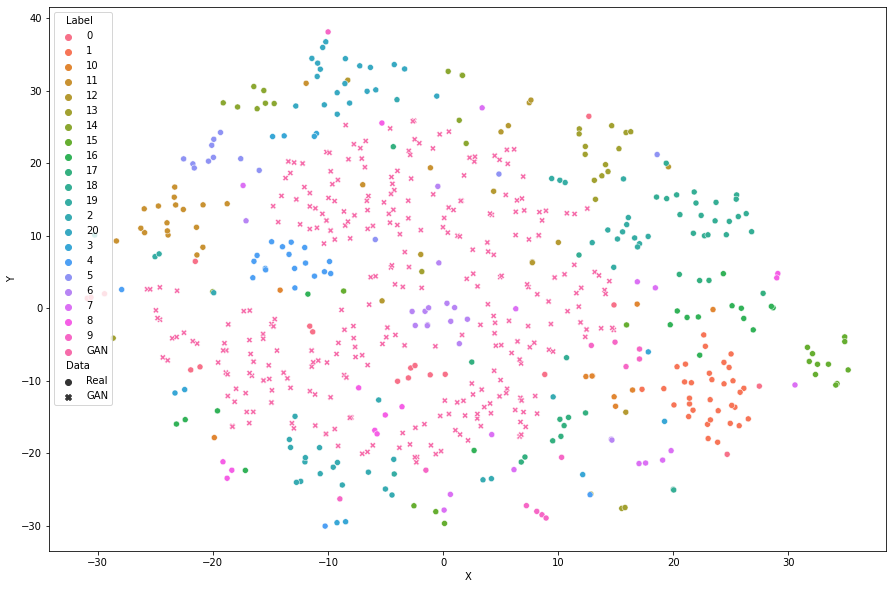

In [23]:
# Generate fake samples
n_sample = 300

with torch.no_grad():
  samples = prior.sample(n_sample)
  X_gen = generator(torch.cat(samples,-1)).detach().numpy()

# Sample real samples
X_real = testset[:]['X']
labels = testset[:]['Y']
labels_long = labels.argmax(-1).numpy()

X_plot = np.concatenate([X_real,X_gen])
X_plot = X_plot.reshape(len(X_plot),-1)
types = np.array(['Real']*len(X_real)+[mode]*len(X_gen))
labels_plot = np.concatenate([labels_long,np.repeat(mode,len(X_gen))])

plot_scatter(X_plot, labels_plot, labels_dict={'Data': types}, method='tsne', style='Data')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


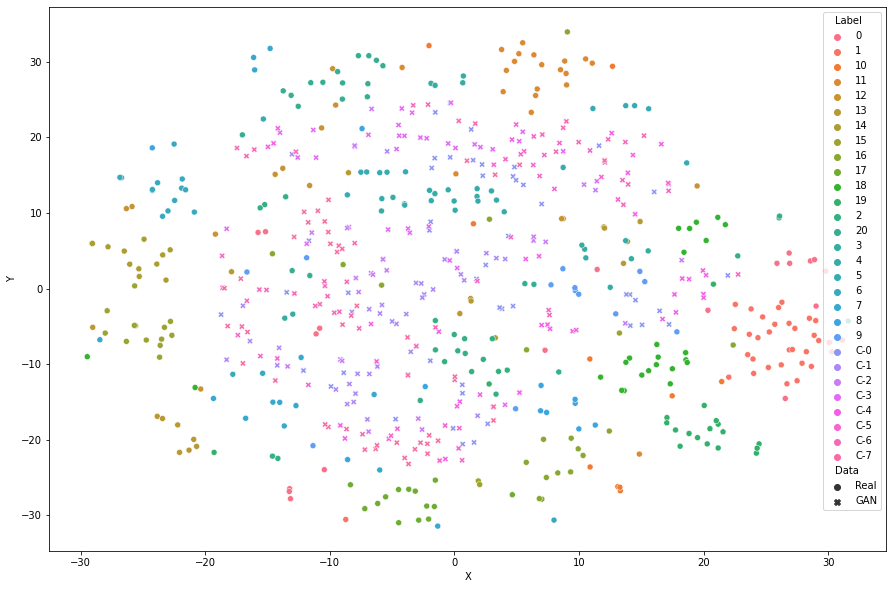

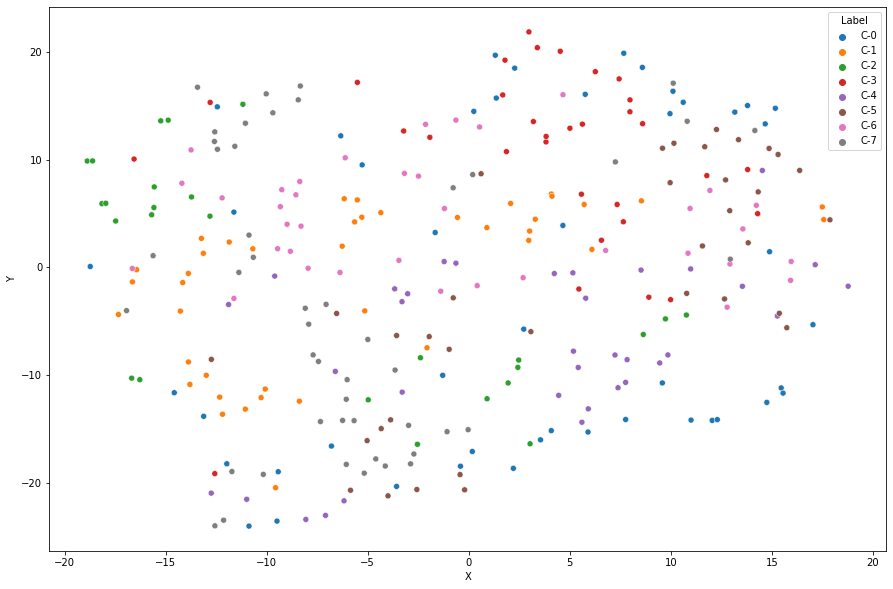

In [24]:
# For InfoGAN visualize the different categorical variables
c1 = samples[0]
labels_gen = np.array(['C-'+str(i) for i in c1.argmax(-1).numpy()])

labels_plot = np.concatenate([labels_long,labels_gen])
plot_scatter(X_plot, labels_plot, labels_dict={'Data': types}, method='tsne', style='Data')

plot_scatter(X_gen.reshape(len(X_gen),-1), labels_gen, method='tsne')

In [25]:
bases = np.array(["A","C","G","T"])
X_gen_long = X_gen.argmax(-1)

pd.DataFrame(bases[X_gen_long]).apply(pd.Series.value_counts).fillna(0).astype('int')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
A,85,51,118,89,60,65,146,80,83,78,34,59,75,91,40,79,54,80,67,72,82,59,41,32,61,49,80,51,54,56,56,80,35,51,38,81,84,58
C,94,113,73,55,95,108,85,48,87,86,90,83,77,51,179,83,94,103,75,99,104,80,74,99,75,84,104,64,57,63,67,82,71,68,89,104,94,66
G,78,57,65,126,112,68,36,98,86,83,80,88,85,83,59,110,66,57,41,75,77,79,61,94,86,43,67,146,84,88,107,84,84,109,106,55,54,83
T,43,79,44,30,33,59,33,74,44,53,96,70,63,75,22,28,86,60,117,54,37,82,124,75,78,124,49,39,105,93,70,54,110,72,67,60,68,93


# Train classifier

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # weights initialization with default method similar to kaiming
    def __init__(self, mode='flatten'):
        super().__init__()
        self.mode   = mode
        if mode == 'conv':
          self.conv1 = nn.Conv1d(38, 6, 5)
          self.pool = nn.MaxPool1d(2, 2)
          self.conv2 = nn.Conv1d(6, 16, 5)
          self.fc1 = nn.Linear(16 * 5 * 5, 96)
        elif mode == 'flatten':
          self.fc1 = nn.Linear(38 * 4, 96)
        self.fc2 = nn.Linear(96, 38)
        # for autoencoder
        # self.fc2 = nn.Linear(96,16)
        # self.fc3 = nn.Linear(16,96)
        # self.fc4 = nn.Linear(96,38*4) # predict flattened version
        self.drop = nn.Dropout(0.2)

    # Forward pass
    def forward(self, x):
        if self.mode == 'conv':
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        # for classifier
        x = self.fc2(x)
        # for autoencoder
        # x = F.relu(self.fc2(x))
        # x = self.drop(x)
        # x = F.relu(self.fc3(x))
        # x = self.drop(x)
        # x = self.fc4(x)
        return x

## Set functions for initializing weights 
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [27]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [28]:
rm -r ./runs

In [29]:
#set up model, loss, and optimizer (L2 applied for all weights)
model = Net

net = model()
# net.apply(init_weights) # custom initialization

criterion = torch.nn.CrossEntropyLoss()
# criterion(pred,input) measures cross entropy loss between pred,input
# pred should be in one-hot encoded format [n_sample, num_base]
# input should be in categorical(long) format
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3) 
# weight decay = L2 regularization
# lr = learning rate


#optimize
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['X'],data['Y']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / i))
    writer.add_scalar('Loss/train', running_loss/i, epoch + 1)

writer.close()

[epoch 1] loss: 2.640
[epoch 2] loss: 0.688
[epoch 3] loss: 0.603
[epoch 4] loss: 0.872
[epoch 5] loss: 0.475
[epoch 6] loss: 0.590
[epoch 7] loss: 0.674
[epoch 8] loss: 1.026
[epoch 9] loss: 0.696
[epoch 10] loss: 0.579
[epoch 11] loss: 0.730
[epoch 12] loss: 0.733
[epoch 13] loss: 0.519
[epoch 14] loss: 0.459
[epoch 15] loss: 0.499
[epoch 16] loss: 0.342
[epoch 17] loss: 0.388
[epoch 18] loss: 0.210
[epoch 19] loss: 0.304
[epoch 20] loss: 0.123
[epoch 21] loss: 0.164
[epoch 22] loss: 0.186
[epoch 23] loss: 0.199
[epoch 24] loss: 0.123
[epoch 25] loss: 0.095
[epoch 26] loss: 0.039
[epoch 27] loss: 0.156
[epoch 28] loss: 0.108
[epoch 29] loss: 0.099
[epoch 30] loss: 0.185
[epoch 31] loss: 0.123
[epoch 32] loss: 0.080
[epoch 33] loss: 0.095
[epoch 34] loss: 0.082
[epoch 35] loss: 0.059
[epoch 36] loss: 0.061
[epoch 37] loss: 0.042
[epoch 38] loss: 0.044
[epoch 39] loss: 0.091
[epoch 40] loss: 0.073
[epoch 41] loss: 0.037
[epoch 42] loss: 0.101
[epoch 43] loss: 0.077
[epoch 44] loss: 0.0

In [30]:
# for classifier only
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data["X"],data["Y"]
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == torch.max(labels,1)[1]).sum().item()

print('Accuracy of the network on test dataset: %d %%' % (
    100 * correct / total))

Accuracy of the network on test dataset: 100 %


In [31]:
with torch.no_grad():
  samples = prior.sample(n_sample)
  X_gen = generator(torch.cat(samples,-1)).detach()

outputs = net(X_gen)
labels_pred = outputs.argmax(-1).numpy()

In [32]:
X_motif = np.array([c[i:i+18] for i,c in zip(labels_pred,X_gen.argmax(-1).numpy())])

counts = np.array([np.sum(X_motif==ii,0) for ii in range(4)]) / len(X_motif)
freq_gen = counts
pd.DataFrame(counts, index = bases)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
A,0.263333,0.336667,0.406667,0.110000,0.130000,0.156667,0.080000,0.536667,0.226667,0.260000,0.146667,0.163333,0.163333,0.296667,0.150000,0.170000,0.093333,0.220000
C,0.376667,0.323333,0.176667,0.166667,0.266667,0.163333,0.666667,0.206667,0.383333,0.236667,0.236667,0.120000,0.140000,0.336667,0.523333,0.543333,0.293333,0.213333
G,0.136667,0.160000,0.296667,0.560000,0.520000,0.173333,0.086667,0.063333,0.240000,0.230000,0.386667,0.236667,0.506667,0.196667,0.150000,0.140000,0.163333,0.363333
T,0.223333,0.180000,0.120000,0.163333,0.083333,0.506667,0.166667,0.193333,0.150000,0.273333,0.230000,0.480000,0.190000,0.170000,0.176667,0.146667,0.450000,0.203333


In [33]:
# Sample real samples
X_real = testset[:]['X']
labels = testset[:]['Y']
labels_long = labels.argmax(-1).numpy()

X_motif = np.array([c[i:i+18] for i,c in zip(labels_long,X_real.argmax(-1).numpy())])
counts = np.array([np.sum(X_motif==ii,0) for ii in range(4)]) / len(X_motif)
freq_real = counts
pd.DataFrame(counts, index = bases)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
A,0.218487,0.442577,0.521008,0.075630,0.050420,0.036415,0.0,0.943978,0.137255,0.179272,0.145658,0.058824,0.176471,0.498599,0.095238,0.128852,0.075630,0.168067
C,0.450980,0.142857,0.042017,0.000000,0.056022,0.053221,1.0,0.002801,0.344538,0.176471,0.170868,0.092437,0.070028,0.277311,0.750700,0.809524,0.252101,0.263305
G,0.176471,0.114846,0.431373,0.770308,0.893557,0.092437,0.0,0.000000,0.316527,0.417367,0.411765,0.067227,0.742297,0.053221,0.005602,0.000000,0.000000,0.380952
T,0.154062,0.299720,0.005602,0.154062,0.000000,0.817927,0.0,0.053221,0.201681,0.226891,0.271709,0.781513,0.011204,0.170868,0.148459,0.061625,0.672269,0.187675


In [36]:
pd.DataFrame({'Real': bases[freq_real.argmax(0)], 
              'Gen':bases[freq_gen.argmax(0)]}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Real,C,A,A,G,G,T,C,A,C,G,G,T,G,A,C,C,T,G
Gen,C,A,A,G,G,T,C,A,C,T,G,T,G,C,C,C,T,G


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


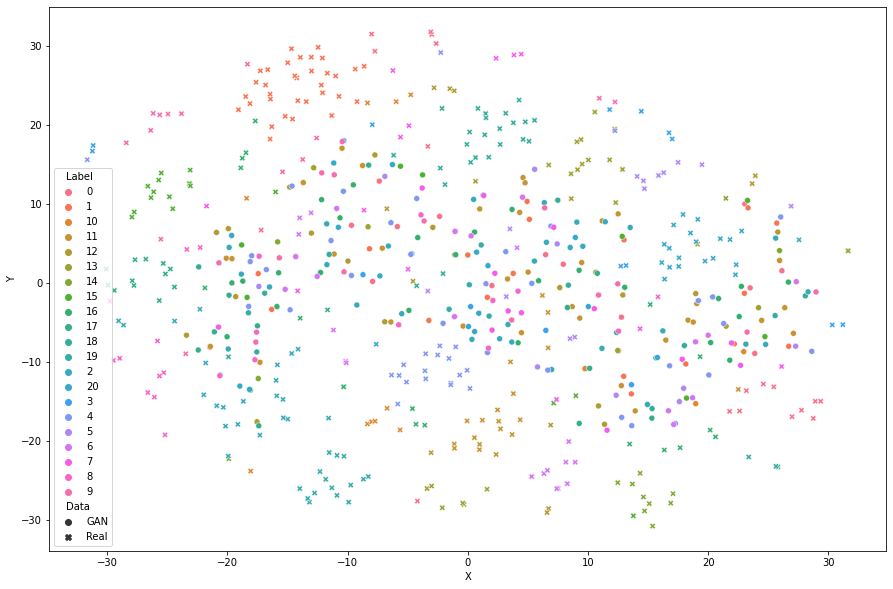

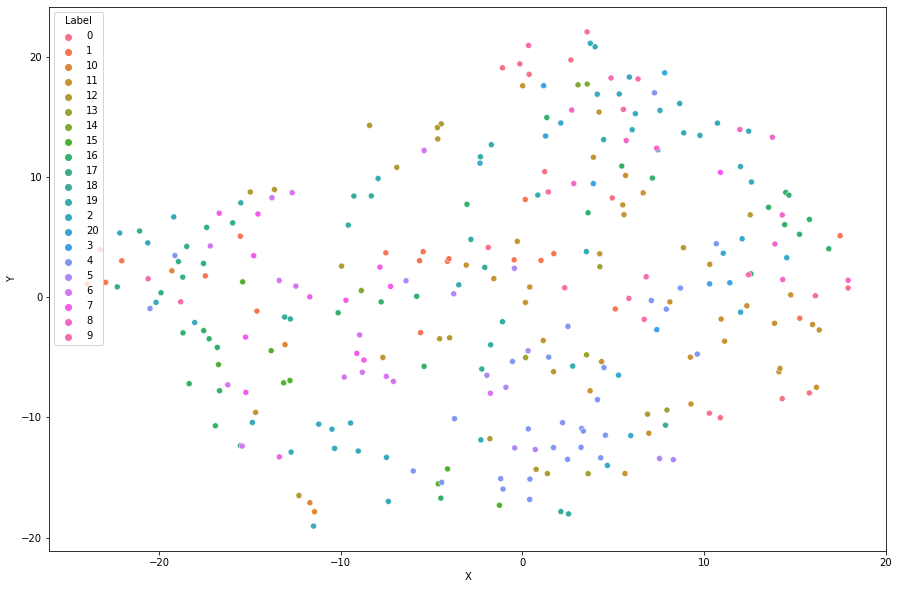

In [37]:
# For InfoGAN visualize the different categorical variables
c1 = samples[0]
labels_gen = labels_pred.astype('str')

labels_plot = np.concatenate([labels_long,labels_gen])
plot_scatter(X_plot, labels_plot, labels_dict={'Data': types}, method='tsne', style='Data')

plot_scatter(X_gen.reshape(len(X_gen),-1), labels_gen, method='tsne')